In [1]:
import numpy as np
import matplotlib.pyplot as plt
from flex_model5 import FlexibleCylinderModel # change model as needed

"""
# model 1 is flexible cylinder as implemented on sasview
# model 2 is flexible cylinder with power law background (representing aggregates) as structure factor
# model 3-5 is flexible cylinder with power law background (representing aggregates) as structure factor + gaussian high q for small molecular scattering
# model 3 uses scipy.optimize.curve_fit, model 4 uses scipy.optimize.least_squares, model 5 removes model normalization with contrast and volume, 
giving the same form as in the paper
"""

# Create model instance
model = FlexibleCylinderModel()
print("Flexible Cylinder Model loaded successfully!")
model.test_model() # the test values have been changed from original sasview source to match current model version

Flexible Cylinder Model loaded successfully!
Testing Python implementation...
q		Expected	Calculated	Rel Error (%)
-------------------------------------------------------
   0.001	  1.052541	  1.052541	     0.0
   1.000	  0.767999	  0.767999	     0.0
   0.100	-18.776337	-18.776337	    -0.0
   1.000	  0.767996	  0.767996	     0.0


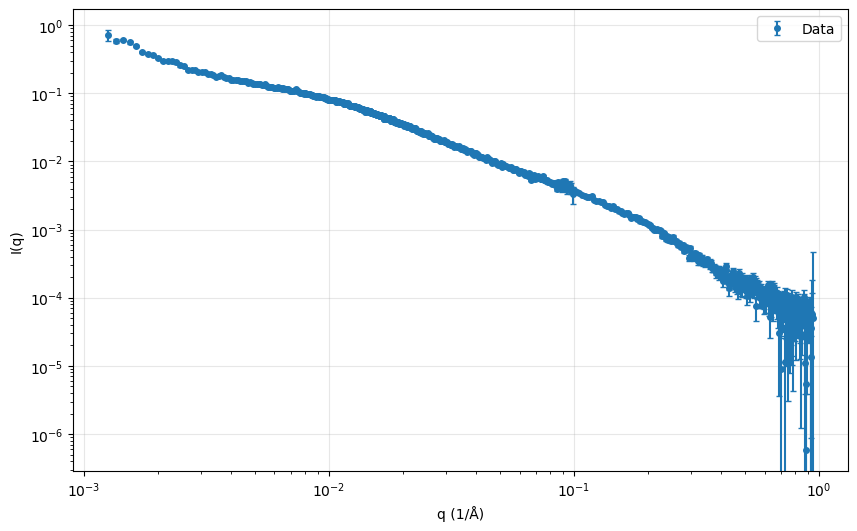

In [2]:
# Generate or load data
# Option 1: Generate data for testing
'''
q_data, intensity_data, uncertainty, true_params = model.generate_synthetic_data(
    q_range=(1e-3, 1.0),
    n_points=50, 
    noise_level=0.05,
    length=800.0,
    kuhn_length=120.0,
    radius=25.0
)

print(f"Generated {len(q_data)} synthetic data points")
print("True parameters:", true_params)
'''

# Option 2: Load data (uncomment and modify as needed)
data = np.loadtxt('AX60-2_1mgml_rebinned.dat', skiprows=0)
q_data = data[:, 0]
intensity_data = data[:, 1]
uncertainty = data[:, 2]


# Plot raw data
plt.figure(figsize=(10, 6))
plt.errorbar(q_data, intensity_data, yerr=uncertainty, 
             fmt='o', markersize=4, capsize=2, label='Data')
plt.xlabel('q (1/Å)')
plt.ylabel('I(q)')
plt.loglog()
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Testing parameters:
----------------------------------------
length         : 851.0000
kuhn_length    :  90.0000
radius         :   9.0000
scale          :   0.0900
background     :   0.0000
pow_scale      :   0.1200
pow_exp        :   1.8200
gauss_scale    : 140.0000
rm             :   5.0000


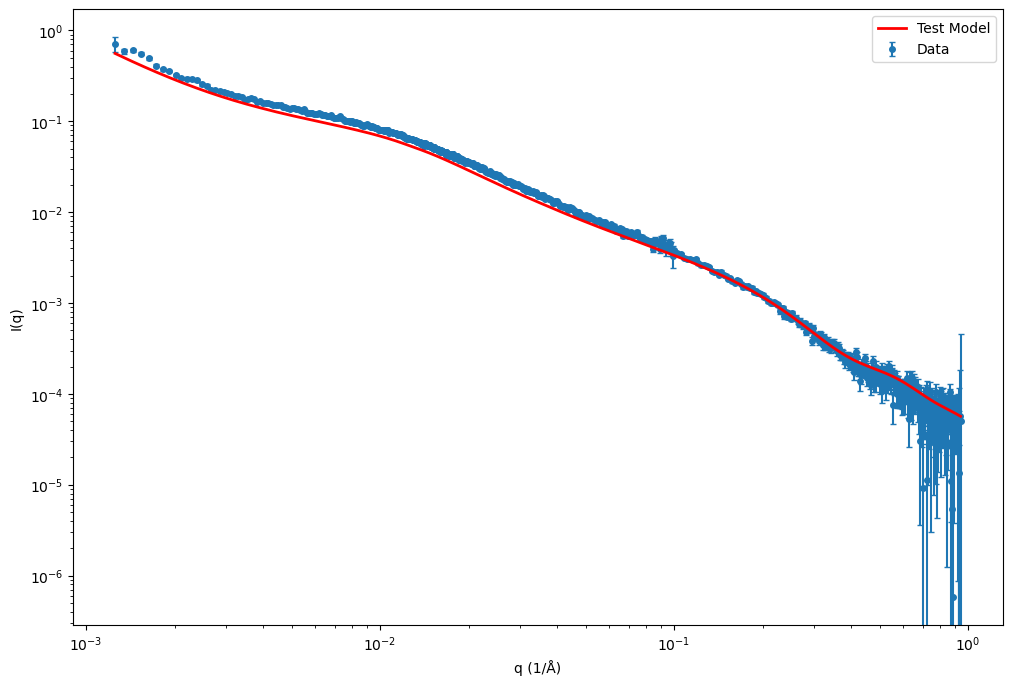

In [5]:
# Manual Parameter Testing

    
# Manual test parameters - modify these as needed
test_params = {
'length': 851,
'kuhn_length': 90,
'radius': 9,
'scale': 0.09,
'background': 0.0000,
'pow_scale': 0.12,
'pow_exp': 1.82,
'gauss_scale': 140, 
'rm': 5
}
    
print("Testing parameters:")
print("-" * 40)
for param, value in test_params.items():
    print(f"{param:15s}: {value:8.4f}")


# Calculate model over q range
q_model = np.logspace(np.log10(q_data.min()), np.log10(q_data.max()), 200)
intensity_model = model.calculate_intensity(q_model, **test_params)
    
plt.figure(figsize=(12, 8))
        
# Main plot
plt.errorbar(q_data, intensity_data, yerr=uncertainty, 
             fmt='o', markersize=4, capsize=2, label='Data', zorder = 1)
plt.plot(q_model, intensity_model, 'r-', linewidth=2, label='Test Model', zorder=2)
plt.loglog()
plt.xlabel('q (1/Å)')
plt.ylabel('I(q)')

plt.legend()
        

In [3]:
# Set up fitting
# Initial parameter guesses
initial_params = {
    'length': 1000.0,
    'kuhn_length': 89,
    'radius': 7,
    'scale': 1.0,
    'background': 0.00001,
    'pow_scale': 0.1,
    'pow_exp': 1.82,
    'gauss_scale': 140,
    'rm': 5.33
}

# Parameter bounds
bounds = {
    'length': (100.0, 3000.0),
    'kuhn_length': (50.0, 500.0),
    'radius': (1, 100.0),
    'scale': (0, 10.0),
    'background': (-0.0001, 1.0), # background can go negative, which is not physical but compensates for added gaussian high q component
    'pow_scale': (0.0, 100.0),
    'pow_exp': (0.0, 4.0),
    'gauss_scale': (0.0, 2000),
    'rm': (0.0, 10.0)
    }

# Optional: fix some parameters during fitting
fixed_params = {
}

print("Fitting setup complete")

Fitting setup complete


In [6]:
# Overwrite initial parameters with previous fitted results, manual chain fitting of sorts.

initial_params = fit_results['fitted_params'].copy()
print("Previous fit parameters:")
for param, value in initial_params.items():
    print(f"  {param}: {value:.6f}")

fixed_params = {
}

Previous fit parameters:
  length: 861.593795
  kuhn_length: 86.159379
  radius: 9.028869
  scale: 0.106010
  background: -0.000032
  pow_scale: 0.127567
  pow_exp: 1.776558
  gauss_scale: 202.407378
  rm: 4.088367


Starting fit...
✓ Fit completed successfully!

Fit Results:
------------------------------------------------------------
length         : 861.593795 ±  12.356851
kuhn_length    :  86.159379 ±   0.000000
radius         :   9.028869 ±   0.147132
scale          :   0.106010 ±   0.001641
background     :  -0.000032 ±   0.000008
pow_scale      :   0.127567 ±   0.009699
pow_exp        :   1.776558 ±   0.038144
gauss_scale    : 202.407378 ±  15.588851
rm             :   4.088367 ±   0.293199
Reduced χ²     :     1.1994

Derived quantities:
L/b ratio      :      10.00
Rg (Å)         :      119.9
Volume (Å³)    :     220658


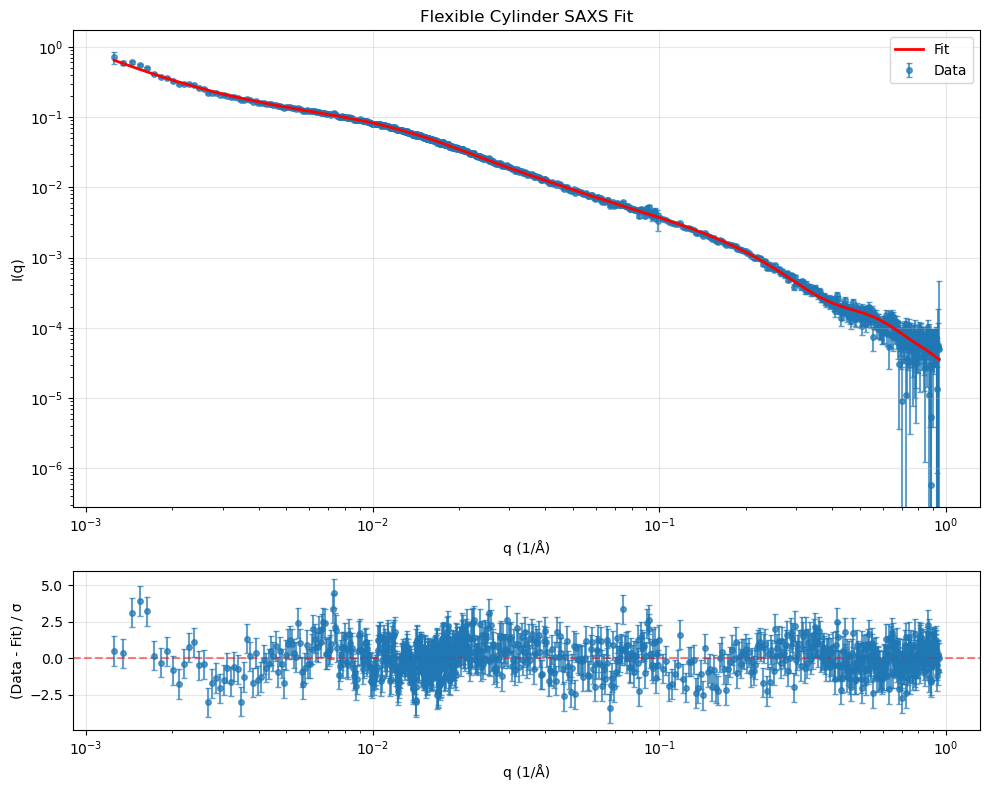

In [4]:
# Jupyter Cell 4: Perform fit
print("Starting fit...")
fit_results = model.fit_data(
    q_data, 
    intensity_data, 
    uncertainty=uncertainty,
    initial_params=initial_params,
    bounds=bounds,
    fixed_params=fixed_params
)

if fit_results['success']:
    print("✓ Fit completed successfully!")
    
    # Plot results
    fig = model.plot_fit(q_data, intensity_data, fit_results, 
                        uncertainty=uncertainty, title="Flexible Cylinder SAXS Fit")
else:
    print(f"✗ Fit failed: {fit_results.get('error', 'Unknown error')}")